# Fast Neural Style Transfer with Instance Normalization
--------------------------------------------------------
### Papers:

### 1. [Perceptual Losses for Real-Time Style Transfer and Super-Resolution (Johnson et al., 2016)](https://arxiv.org/pdf/1603.08155.pdf)

### 2. [Instance Normalization: The Missing Ingredient for Fast Stylization (Ulyanov et al., 2017)](https://arxiv.org/pdf/1607.08022.pdf)

### GitHub: [PyTorch Implementation of Fast Neural Style Transfer with Instance Normalization (Johnson et al., 2016)](https://github.com/jcjohnson/fast-neural-style)

- Import libraries

In [ ]:
# Notebook display
from PIL import Image
from google.colab import files
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tqdm.notebook import trange, tqdm_notebook

# PyTorch
import torch
from torch.optim import Adam
import torch.nn.functional as F
from torchvision import transforms
from torchvision.datasets import CocoDetection
from torch.hub import load_state_dict_from_url
from torch.utils.data import DataLoader, Dataset
from torch.nn import Module, Sequential, Upsample, ReflectionPad2d, Conv2d, InstanceNorm2d, ReLU, MaxPool2d

- Define constants and image processing functions

In [ ]:
# Image size
SIZE = 512

# ImageNet statistics
MEAN = (0.485, 0.456, 0.406)
STD = (0.229, 0.224, 0.225)

# Determine device
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Pre-processing
def prep(image, size=SIZE, normalize=True, mean=MEAN, std=STD, device=DEVICE):
    resize = transforms.Compose([transforms.Resize(size, Image.LANCZOS),
                                 transforms.CenterCrop(size)])
    image = resize(image.convert('RGB'))
    if normalize:
        norm = transforms.Compose([transforms.ToTensor(),
                                   transforms.Normalize(mean, std)])
        return norm(image).unsqueeze(0).to(device)
    else:
        return image

# Post-processing
def post(tensor, mean=MEAN, std=STD):
    mean, std = torch.tensor(mean).view(3, 1, 1), torch.tensor(std).view(3, 1, 1)
    tensor = transforms.Lambda(lambda x: x * std + mean)(tensor.cpu().clone().squeeze(0))
    return transforms.ToPILImage()(tensor.clamp_(0, 1))

# Draw content, style and output images
def draw(input, content_image, style_image):
    output = post(input)

    clear_output(wait=True)
    plt.figure(figsize=(18, 6))

    ax1 = plt.subplot(1, 3, 1)
    ax1.imshow(prep(content_image, normalize=False))
    ax1.axis('off')
    ax1.set_title('Content Image')

    ax2 = plt.subplot(1, 3, 2)
    ax2.imshow(prep(style_image, normalize=False))
    ax2.axis('off')
    ax2.set_title('Style Image')

    ax3 = plt.subplot(1, 3, 3)
    ax3.imshow(output)
    ax3.axis('off')
    ax3.set_title('Output Image')

    plt.show()
    return output

- Upload content and style images

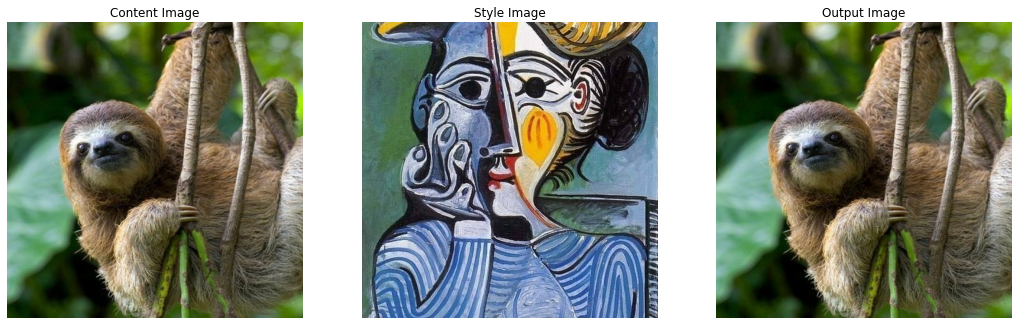

In [ ]:
# Manually upload images
# files.upload()

# Open and prepare images
content_image, style_image = Image.open('content.jpg'), Image.open('picasso_style.jpg')
content, style = prep(content_image), prep(style_image)

# Display images
_ = draw(content, content_image, style_image)

- Define content and style losses

In [ ]:
class ContentLoss(Module):
    def forward(self, features, targets):
        loss = F.mse_loss(features, targets)
        return loss


class StyleLoss(Module):
    def forward(self, features, GM_t):
        GM_f = self.gram_matrix(features)
        loss = F.mse_loss(GM_f, GM_t)
        return loss
    
    @staticmethod
    def gram_matrix(inputs):
        BS, C, H, W = inputs.size()
        inputs = inputs.view(BS, C, H * W)
        GM = inputs.bmm(inputs.transpose(1, 2))
        return GM.div_(C * H * W)

- Define Image Transformation Network with nearest neighbour upsampling, instead of transposed convolutions, for better performance

In [ ]:
class ConvBlock(Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, upsample=False, norm=True, relu=True):
        super().__init__()

        self.upsample = Upsample(scale_factor=2) if upsample else None
        self.conv_block = Sequential(ReflectionPad2d(kernel_size // 2), Conv2d(in_channels, out_channels, kernel_size, stride))
        self.norm = InstanceNorm2d(out_channels, affine=True) if norm else None
        self.relu = ReLU(inplace=True) if relu else None

    def forward(self, x):
        if self.upsample:
            x = self.upsample(x)
        conv = self.conv_block(x)
        if self.norm:
            conv = self.norm(conv)
        if self.relu:
            conv = self.relu(conv)
        return conv


class ResBlock(Module):
    def __init__(self, channels):
        super().__init__()
        
        self.conv_blocks = Sequential(ConvBlock(channels, channels, kernel_size=3),
                                      ConvBlock(channels, channels, kernel_size=3, relu=False))

    def forward(self, x):
        return self.conv_blocks(x) + x


class ImageTransformationNetwork(Module):
    def __init__(self, num_res_blocks=5):
        super().__init__()

        self.transnet = Sequential(ConvBlock(3, 32, kernel_size=9, stride=1),
                                   ConvBlock(32, 64, kernel_size=3, stride=2),
                                   ConvBlock(64, 128, kernel_size=3, stride=2),
                                   *[ResBlock(128) for i in range(num_res_blocks)],
                                   ConvBlock(128, 64, kernel_size=3, upsample=True),
                                   ConvBlock(64, 32, kernel_size=3, upsample=True),
                                   ConvBlock(32, 3, kernel_size=9, norm=False, relu=False))

    def forward(self, x):
        return self.transnet(x)

- Define VGG-16

In [ ]:
class VGG16(Module):
    def __init__(self):
        super().__init__()

        # Feature Extractor
        self.conv1_1 = Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv1_2 = Conv2d(64, 64, kernel_size=3, padding=1)
        self.pool1 =   MaxPool2d(kernel_size=2, stride=2)
            
        self.conv2_1 = Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv2_2 = Conv2d(128, 128, kernel_size=3, padding=1)
        self.pool2 =   MaxPool2d(kernel_size=2, stride=2)
            
        self.conv3_1 = Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv3_2 = Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv3_3 = Conv2d(256, 256, kernel_size=3, padding=1)
        self.pool3 =   MaxPool2d(kernel_size=2, stride=2)
            
        self.conv4_1 = Conv2d(256, 512, kernel_size=3, padding=1)
        self.conv4_2 = Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv4_3 = Conv2d(512, 512, kernel_size=3, padding=1)
        self.pool4 =   MaxPool2d(kernel_size=2, stride=2)
            
        self.conv5_1 = Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_2 = Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_3 = Conv2d(512, 512, kernel_size=3, padding=1)
        self.pool5 =   MaxPool2d(kernel_size=2, stride=2)
        
        # Freeze Parameters
        for param in self.parameters():
            param.requires_grad = False

    def forward(self, x, out_layers):
        out = dict()
        
        out['conv1_1'] = F.relu(self.conv1_1(x))
        out['conv1_2'] = F.relu(self.conv1_2(out['conv1_1']))
        out['pool1'] = self.pool1(out['conv1_2'])

        out['conv2_1'] = F.relu(self.conv2_1(out['pool1']))
        out['conv2_2'] = F.relu(self.conv2_2(out['conv2_1']))
        out['pool2'] = self.pool2(out['conv2_2'])

        out['conv3_1'] = F.relu(self.conv3_1(out['pool2']))
        out['conv3_2'] = F.relu(self.conv3_2(out['conv3_1']))
        out['conv3_3'] = F.relu(self.conv3_3(out['conv3_2']))
        out['pool3'] = self.pool3(out['conv3_3'])

        out['conv4_1'] = F.relu(self.conv4_1(out['pool3']))
        out['conv4_2'] = F.relu(self.conv4_2(out['conv4_1']))
        out['conv4_3'] = F.relu(self.conv4_3(out['conv4_2']))
        out['pool4'] = self.pool4(out['conv4_3'])

        out['conv5_1'] = F.relu(self.conv5_1(out['pool4']))
        out['conv5_2'] = F.relu(self.conv5_2(out['conv5_1']))
        out['conv5_3'] = F.relu(self.conv5_3(out['conv5_2']))
        out['pool5'] = self.pool5(out['conv5_3'])

        return [out[layer] for layer in out_layers]

- Initialize networks and load VGG-16 pre-trained weights & biases

In [ ]:
vgg16 = VGG16().to(DEVICE)
transnet = ImageTransformationNetwork().to(DEVICE)

state = vgg16.state_dict()
pretrained_vgg16 = 'https://download.pytorch.org/models/vgg16-397923af.pth'
new_state_values = list(load_state_dict_from_url(pretrained_vgg16).values())

for i, key in enumerate(state):
    state[key] = new_state_values[i]

vgg16.load_state_dict(state)

<All keys matched successfully>

### Training stage (skip if you have pre-trained weights)

- Load MS-COCO 2014 Train Dataset

In [ ]:
# !wget http://images.cocodataset.org/annotations/annotations_trainval2014.zip
# !wget http://images.cocodataset.org/zips/train2014.zip
# !unzip annotations_trainval2014
# !unzip train2014

Streaming output truncated to the last 5000 lines.
 extracting: train2014/COCO_train2014_000000408557.jpg  
 extracting: train2014/COCO_train2014_000000013714.jpg  
 extracting: train2014/COCO_train2014_000000194043.jpg  
 extracting: train2014/COCO_train2014_000000219859.jpg  
 extracting: train2014/COCO_train2014_000000278135.jpg  
 extracting: train2014/COCO_train2014_000000141015.jpg  
 extracting: train2014/COCO_train2014_000000280923.jpg  
 extracting: train2014/COCO_train2014_000000200024.jpg  
 extracting: train2014/COCO_train2014_000000435713.jpg  
 extracting: train2014/COCO_train2014_000000249993.jpg  
 extracting: train2014/COCO_train2014_000000424160.jpg  
 extracting: train2014/COCO_train2014_000000142761.jpg  
 extracting: train2014/COCO_train2014_000000532668.jpg  
 extracting: train2014/COCO_train2014_000000564904.jpg  
 extracting: train2014/COCO_train2014_000000346384.jpg  
 extracting: train2014/COCO_train2014_000000560934.jpg  
 extracting: train2014/COCO_train2014

In [ ]:


image2tensor = transforms.Compose([transforms.Resize(256, Image.LANCZOS),
                                   transforms.CenterCrop(256),
                                   transforms.ToTensor(),
                                   transforms.Normalize(MEAN, STD)])

train_dataset = CocoDetection('train2014', 'annotations/instances_train2014.json', image2tensor)
train_loader = DataLoader(train_dataset, batch_size=4, collate_fn=lambda batch: torch.stack([x[0] for x in batch]))
clear_output()

- Pre-compute targets and initialize losses

In [ ]:
# Layers of content/style reconstruction
content_layers = ['conv2_2']
style_layers = ['conv1_2', 'conv2_2', 'conv3_3', 'conv4_3']
num_style_layers = len(style_layers)

# Style targets
style_tensors = style.repeat(4, 1, 1, 1)
style_targets = [StyleLoss.gram_matrix(target) for target in vgg16(style_tensors, style_layers)]

# Loss functions
content_loss_fn = ContentLoss()
style_loss_fn = StyleLoss()

# Loss weights
CONTENT_WEIGHT = 1
STYLE_WEIGHT = 1e5
TV_WEIGHT = 1e-6

- Train ImageTransformationNetwork on the chosen style

In [ ]:
def train(transnet, train_loader, style_targets, content_loss_fn, style_loss_fn, epochs=2):
    num_batches = len(train_loader)
    optimizer = Adam(transnet.parameters(), lr=1e-3)

    for epoch in trange(epochs, desc='Epochs'):
        batches = iter(train_loader)
        for batch_idx in tqdm_notebook(range(1, num_batches + 1), desc='Batches', leave=False):
            batch = next(batches).to(DEVICE)
            images_in_batch = len(batch)

            optimizer.zero_grad()
            vgg16_out = vgg16(batch, content_layers)
            transnet_out = transnet(batch)
            vgg16_transnet_out = vgg16(transnet_out, style_layers)

            # Content Loss
            content_preds, content_targets = vgg16_transnet_out[1], vgg16_out[0]
            content_loss = CONTENT_WEIGHT * content_loss_fn(content_preds, content_targets)
            
            # Style Loss
            style_loss = 0
            for i in range(num_style_layers):
                style_loss += style_loss_fn(vgg16_transnet_out[i], style_targets[i][:images_in_batch])
            style_loss *= STYLE_WEIGHT
            
            # Total Variation Regularization
            diff_i = ((transnet_out[:, :, :, 1:] - transnet_out[:, :, :, :-1]).abs()).sum()
            diff_j = ((transnet_out[:, :, 1:, :] - transnet_out[:, :, :-1, :]).abs()).sum()
            tv_reg = TV_WEIGHT * (diff_i + diff_j)

            total_loss = style_loss + content_loss + tv_reg
            total_loss.backward()
            optimizer.step()

    # Save the trained weights
    torch.save(transnet.state_dict(), 'picasso.pth')

# Run
train(transnet, train_loader, style_targets, content_loss_fn, style_loss_fn)

Epochs:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/20696 [00:00<?, ?it/s]

Batches:   0%|          | 0/20696 [00:00<?, ?it/s]

### Inference step

- Transfer style

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:333: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


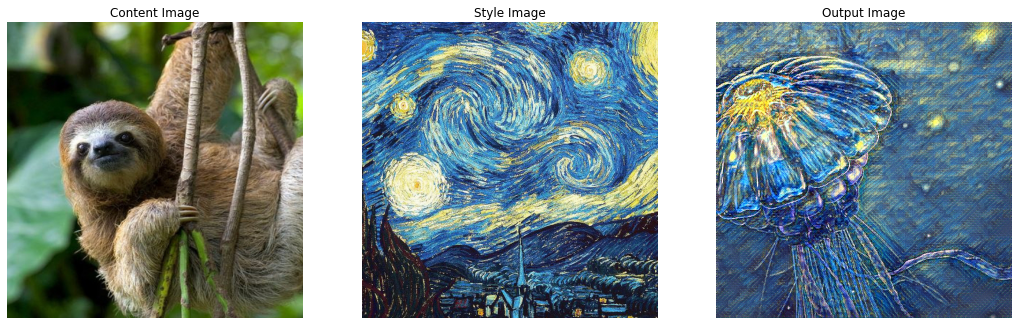

CPU times: user 468 ms, sys: 14.1 ms, total: 482 ms
Wall time: 481 ms


In [ ]:
%%time

def transfer_style(transnet, content):
    transnet.eval()
    with torch.no_grad():
        output = draw(transnet(content), content_image, style_image)
    return output

# Run
transnet.load_state_dict(torch.load('van_gogh.pth'))
output = transfer_style(transnet, check)

- Save and download output

In [ ]:
output.save('output.png')
files.download('output.png')